# SOLUTION ARGHHH
### FUCK, I have not slept in 3 days.
##### I''m only alive with pills. I wanna KMS.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

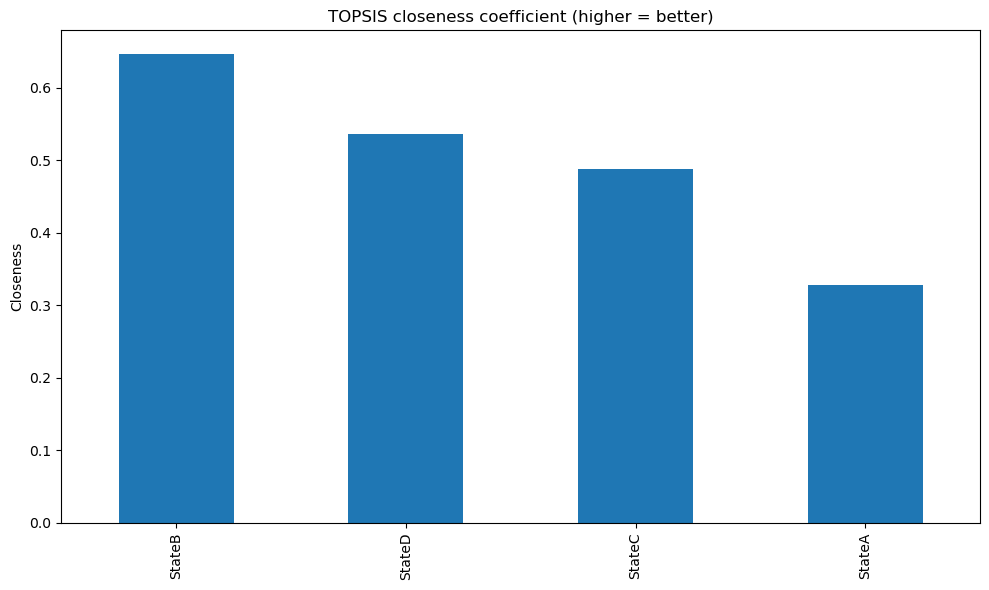

TOPSIS ranking (higher closeness = better):
         closeness  distance_to_ideal_positive  distance_to_ideal_negative  \
StateB   0.646587                    0.058543                    0.107108   
StateD   0.535673                    0.100133                    0.115519   
StateC   0.487339                    0.114627                    0.108965   
StateA   0.327177                    0.116008                    0.056412   

        rank  
StateB     1  
StateD     2  
StateC     3  
StateA     4  


In [ ]:
def weighted_topsis(df, criteria, weights=None, criteria_types=None, eps=1e-12, plot=False):
    """
    Perform weighted TOPSIS.
    Args:
        df: pandas.DataFrame, rows = alternatives (states), cols include the criteria
        criteria: list of column names in df to use (order matters)
        weights: list or np.array of positive weights (same length as criteria). If None, equal weights used.
        criteria_types: list of 'benefit' or 'cost' strings (same length as criteria). If None, defaults:
                        all 'cost' except those explicitly benefit (waste_diversion, water_reuse).
        eps: small number to avoid division by zero
        plot: if True, show a bar chart of closeness coefficients
    Returns:
        pandas.DataFrame with columns:
            - closeness (higher = better)
            - rank (1 = best)
            - distance_to_ideal_positive
            - distance_to_ideal_negative
    """

    # Basic checks
    n_crit = len(criteria)
    A = df[criteria].astype(float).copy()

    if weights is None:
        weights = np.ones(n_crit) / n_crit
    else:
        weights = np.array(weights, dtype=float)

        if weights.shape[0] != n_crit:
            raise ValueError("weights length must match number of criteria")
        if np.any(weights < 0):
            raise ValueError("weights must be non-negative")
        
        wsum = weights.sum()

        if wsum <= 0:
            raise ValueError("sum of weights must be > 0")
        
        weights = weights / wsum

    # Default criteria_types if not provided
    if criteria_types is None:
        default_benefits = {'waste_diversion', 'water_reuse'}
        criteria_types = ['benefit' if c in default_benefits else 'cost' for c in criteria]
    if len(criteria_types) != n_crit:
        raise ValueError("criteria_types length must match number of criteria")

    # 1) Vector normalization (sqrt-sum-sq)
    norm = np.sqrt((A**2).sum(axis=0)) + eps  # shape (n_crit,)
    R = A / norm

    # 2) Weighted normalized decision matrix
    V = R * weights

    # 3) Determine ideal best (A+) and ideal worst (A-)
    ideal_pos = np.zeros(n_crit)
    ideal_neg = np.zeros(n_crit)
    
    for i, c in enumerate(criteria):
        if criteria_types[i].lower() == 'benefit':
            ideal_pos[i] = V[c].max()
            ideal_neg[i] = V[c].min()
        else:  # cost
            ideal_pos[i] = V[c].min()
            ideal_neg[i] = V[c].max()

    # 4) Distances to ideal positive and negative
    diff_pos = V - ideal_pos
    diff_neg = V - ideal_neg
    dist_pos = np.sqrt((diff_pos**2).sum(axis=1))
    dist_neg = np.sqrt((diff_neg**2).sum(axis=1))

    # 5) Closeness coefficient
    closeness = dist_neg / (dist_pos + dist_neg + eps)

    result = pd.DataFrame({
        'closeness': closeness,
        'distance_to_ideal_positive': dist_pos,
        'distance_to_ideal_negative': dist_neg
    }, index=df.index)

    result['rank'] = result['closeness'].rank(ascending=False, method='min').astype(int)
    result = result.sort_values(['closeness'], ascending=False)

    if plot:
        ax = result['closeness'].plot.bar(figsize=(10,6), title='TOPSIS closeness coefficient (higher = better)')
        
        ax.set_ylabel('Closeness')
        plt.tight_layout()
        plt.show()

    return result

# -------------------------
# Example usage with mock data
# -------------------------
if __name__ == "__main__":
    # Mock dataset for demonstration (replace with your real data)
    data = {
        'CO2_transport':     [1200,  900,  600, 1400],  # tCO2 (lower better)
        'dist_to_airport':   [40,    20,   80,   10],  # km (lower better)
        'waste_diversion':   [0.35,  0.50, 0.60, 0.40], # fraction (higher better)
        'water_reuse':       [0.05,  0.12, 0.20, 0.08], # fraction (higher better)
        'water_stress':      [0.7,   0.4,  0.8,  0.3],  # index (lower better)
        'people_days':       [50000, 45000, 70000, 20000], # people-days (lower better)
        'CO2_grid':          [0.45,  0.35, 0.25, 0.50], # kgCO2/kWh (lower better)
        'stadium_energy':    [350000,250000,480000,200000] # kWh per game (lower better)
    }
    states = ['StateA', 'StateB', 'StateC', 'StateD']
    df_example = pd.DataFrame(data, index=states)

    # Criteria order (must match columns used from df)
    criteria = ['CO2_transport','dist_to_airport','waste_diversion','water_reuse',
                'water_stress','people_days','CO2_grid','stadium_energy']

    # Example weights (you should set these to reflect importance)
    # Sum doesn't need to be 1; function normalizes to sum=1 internally.
    weights = [0.18, 0.10, 0.15, 0.10, 0.12, 0.12, 0.15, 0.08]
    # criteria types: explicitly mark benefit/cost
    criteria_types = ['cost','cost','benefit','benefit','cost','cost','cost','cost']

    # Run TOPSIS
    ranking = weighted_topsis(df_example, criteria, weights=weights, criteria_types=criteria_types, plot=True)
    print("TOPSIS ranking (higher closeness = better):\n", ranking)
